# DSCI 100 Group Project Report (Group 17)
## Factors of Toxicity of Mushrooms (Chosen Data Set: Mushrooms)

In [36]:
library(tidyverse)
library(tidymodels)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



Parsed with column specification:
cols(
  .default = col_character(),
  bruises = col_logical(),
  `gill-attachment` = col_logical()
)

See spec(...) for full column specifications.

Warning message:
“210 parsing failures.
 row             col           expected actual                                                                                     file
6039 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv'
6041 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv'
6376 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv'
6425 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv'
6435 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-1

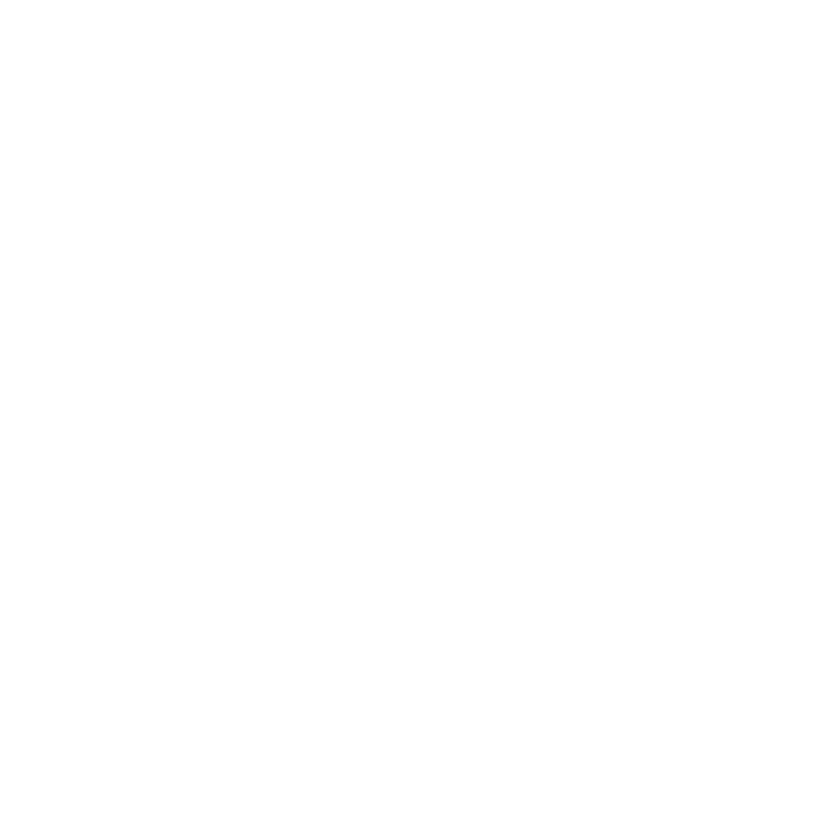

In [65]:
set.seed(87)
data <- read_csv("https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv")
# to make the column names usable with ggplot and other commands, hyphens do not work
colnames(data) <- make.names(colnames(data))
filtered <- data %>% select(cap.color, gill.color, ring.type, class)
split <- initial_split(filtered, prop = 0.75, Strata = class)
train <- training(split)
test <- testing(split)
plot <- ggplot(data, aes(x=cap.color)) +
        geom_histogram(binwidth=1)
plot

### Introduction

#### Background Information

text here

### Methodology

text here

### Results

text here

### Discussion

text here

***
## Appendix

#### Bibliography

* text here